In [1]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import re
import networkx as nx
%matplotlib inline

In [2]:
import itertools
import random
import statistics
from itertools import islice


In [3]:
from scipy.stats import power_divergence

In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
from network import *

In [6]:
import math

In [7]:
from loaders import *

In [8]:
from IPython.core.display import Image, display

In [9]:

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [10]:
def plot_dict(stat, xlbl, ylbl):
    plt.plot([x for x in stat.keys()], [x for x in stat.values()])
    plt.xlabel(xlbl)
    plt.ylabel(ylbl)
    plt.show()

In [11]:
def plot_weighet_graph(graph, weights=None):
    if weights == None:
        weights = [1] * len(graph.nodes())
    
    nodesize = [weights[v] * 10000 for v in graph]
    try:
        pos=nx.nx_agraph.graphviz_layout(graph)
    except:
        pos=nx.spring_layout(graph,iterations=20)
    nx.draw(graph, node_size=nodesize, pos=pos, node_color="w")
    nx.draw_networkx_labels(graph, pos)
    

In [12]:
def get_time_seriece(weights_per_period, node):
    return [weights.get(node, 0.0) for weights in weights_per_period]

In [13]:
def get_weights_in_period(file ,start, end):
    coauthorNetwork = load_with_loader(file, parse_dataset_file, lambda article: start <= article.year < end)
    (auth_subgraph, auth_weights, auth_sorted_nodes) = calc_pagerank(coauthorNetwork.gr)
    (cite_subgraph, cite_weights, cite_sorted_nodes) = calc_pagerank(coauthorNetwork.cgr)
    print("Top researchers", cite_sorted_nodes[:10])
    return ((auth_weights, auth_sorted_nodes), (cite_weights, cite_sorted_nodes) )

In [14]:
coauthorNetwork = CoauthorNetwork.load_with_loader("./data/out_test.txt", parse_dataset_file);


#run_analyse("./data/out_test.txt")
#run_analyse("./data/authors/Database.txt")
#run_analyse("./data/authors/Data Mining.txt")
#run_analyse("./data/authors/Theory.txt")
#run_analyse("./data/authors/Visualization.txt")


Uniq authors: 18328


 
Connected component distribution (log-scale)


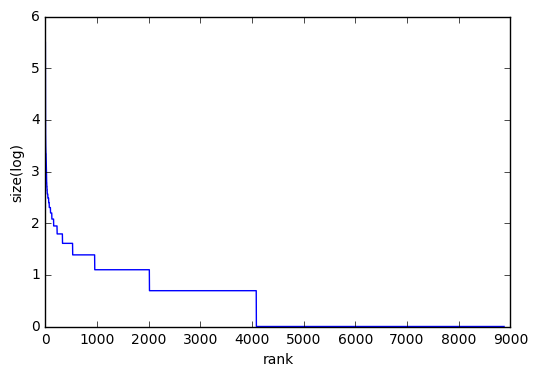

Power_divergenceResult(statistic=56199.791357485825, pvalue=0.0)
Connected component count: 8879
----------
Authors count: 244
Mean distance: 6.92155737704918
 
Distance distribution


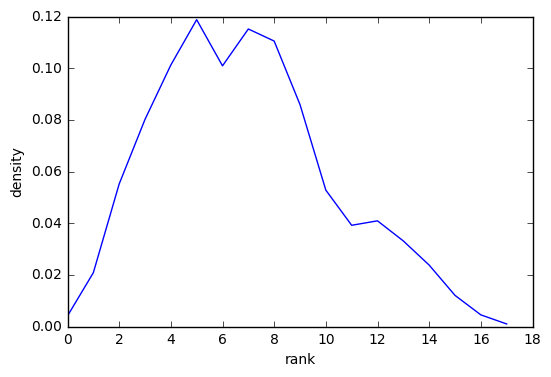

Top 10 authors by degree centrality measurement: [('John J. Tyson', 0.0006002073443553227), ('Wei Wang', 0.0005456430403230207), ('Amos Ng', 0.0004910787362907187), ('Gilles Muller', 0.0004910787362907187), ('Jonathan Shapiro', 0.0004910787362907187), ('Kenneth Carvin', 0.00043651443225841655), ('Herbert Bos', 0.0003273858241938124), ('Bengt Göransson', 0.0003273858241938124), ('Leonid I. Perlovsky', 0.0003273858241938124), ('Marco Colombetti', 0.0003273858241938124)]
Top 10 authors by betweenness centrality measurement: [('Grzegorz W. Wasilkowski', 0.0), ('Gang Qi', 0.0), ('Jim Z. C. Lai', 0.0), ('Chih-Wei Ho', 0.0), ('Maria Jesus Luque', 0.0), ('Atul J. Butte', 0.0), ('Sergio F. Ochoa', 0.0), ('Thomas E. Vollmann', 0.0), ('Richard T. B. Ma', 0.0), ('Joan F. Lorenz', 0.0)]
Top 10 authors by closeness centrality measurement: [('Jonathan Shapiro', 0.0005078677529160423), ('John J. Tyson', 0.0004910787362907187), ('Gilles Muller', 0.0004910787362907187), ('Wei Wang', 0.000436514432258416

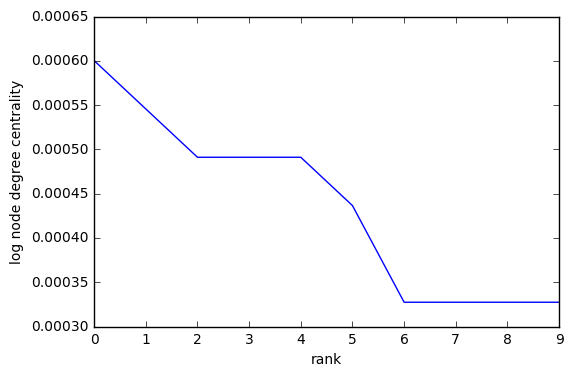

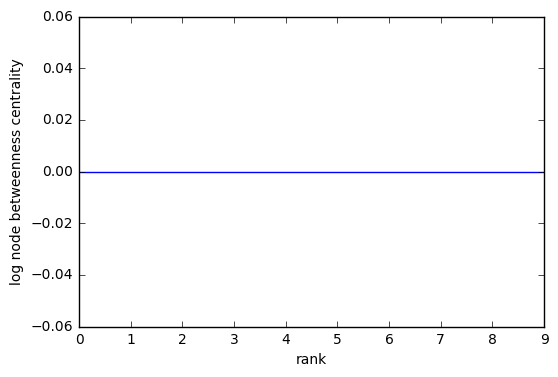

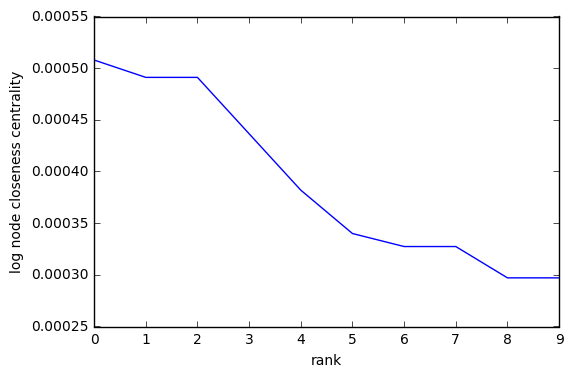

In [15]:
coauthorNetwork.gen_components()
coauthorNetwork.analize_component()
coauthorNetwork.print_info_component()

In [16]:
def calculate_cite_author_quantity_distribution(file, start, end):
    coauthor_network = CoauthorNetwork.load_with_loader(file, parse_dataset_file, lambda article: start <= article.year < end)
    dist = coauthor_network.calc_coauthor_cite_distribution()
    plot_pairs(dist[0], "number of coauthors", "article quantity")
    plot_pairs(dist[1], "number of citations", "article quantity")

# calculate_cite_author_quantity_distribution("./data/out_test.txt", 2000, 2001)

In [17]:
# Analyse time series
'''
file = "./data/out_test.txt"

coauthorNetwork = load_with_loader(file, parse_dataset_file)
nodes_count = len(coauthorNetwork.gr.nodes())

train_authros = coauthorNetwork.gr.nodes()[:nodes_count // 2]
test_authors = coauthorNetwork.gr.nodes()[nodes_count // 2:]

weights_per_period = []
weights_per_period.append(get_weights_in_period(file, 1990, 1995))
weights_per_period.append(get_weights_in_period(file, 1995, 2000))
weights_per_period.append(get_weights_in_period(file, 2000, 2005))
weights_per_period.append(get_weights_in_period(file, 2005, 2010))

weights_per_period_auth = [ w[0][0] for w in weights_per_period ]
weights_per_period_cite = [ w[1][0] for w in weights_per_period ]

x_train = [get_time_seriece(weights_per_period_auth, author) 
           + get_time_seriece(weights_per_period_cite[0:-1], author) for author in test_authors]
y_train = [weights_per_period_cite[-1].get(author, 0.0) for author in test_authors ]

# print("x_train", x_train[0:10])
# print("y_train", y_train[0:10])
x_test = [get_time_seriece(weights_per_period_auth, author) 
           + get_time_seriece(weights_per_period_cite[0:-1], author) for author in test_authors]
y_test = [weights_per_period_cite[-1].get(author, 0.0) for author in test_authors ]

lm = LinearRegression(normalize=True)
lm.fit(x_train, y_train)

for pair in zip(lm.predict(x_test)[0:10], y_test[0:10]):
    print(pair)
    
# print(lm.predict(x_test)[0:10])
# print(y_test[0:10])
'''


'\nfile = "./data/out_test.txt"\n\ncoauthorNetwork = load_with_loader(file, parse_dataset_file)\nnodes_count = len(coauthorNetwork.gr.nodes())\n\ntrain_authros = coauthorNetwork.gr.nodes()[:nodes_count // 2]\ntest_authors = coauthorNetwork.gr.nodes()[nodes_count // 2:]\n\nweights_per_period = []\nweights_per_period.append(get_weights_in_period(file, 1990, 1995))\nweights_per_period.append(get_weights_in_period(file, 1995, 2000))\nweights_per_period.append(get_weights_in_period(file, 2000, 2005))\nweights_per_period.append(get_weights_in_period(file, 2005, 2010))\n\nweights_per_period_auth = [ w[0][0] for w in weights_per_period ]\nweights_per_period_cite = [ w[1][0] for w in weights_per_period ]\n\nx_train = [get_time_seriece(weights_per_period_auth, author) \n           + get_time_seriece(weights_per_period_cite[0:-1], author) for author in test_authors]\ny_train = [weights_per_period_cite[-1].get(author, 0.0) for author in test_authors ]\n\n# print("x_train", x_train[0:10])\n# print(

In [18]:
coauthorNetwork = CoauthorNetwork.load_with_loader("./data/out_test.txt", parse_dataset_file, lambda article: 1970 <= article.year < 2010)
print(coauthorNetwork.top_authors_cite_coauth_stat())

Uniq authors: 18322
[Counter({2003: 17, 2005: 2, 2004: 1, 2006: 1}), Counter({2006: 8, 2007: 1}), Counter({2006: 4, 2005: 2, 2004: 1, 2007: 1}), Counter({2006: 5, 2005: 2, 2004: 1}), Counter({2006: 11, 2005: 7, 2004: 6, 2003: 3, 2002: 2, 2007: 2}), Counter({2006: 11, 2005: 7, 2004: 6, 2003: 3, 2002: 2, 2007: 2}), Counter({2006: 5, 2005: 2, 2004: 1}), Counter({2005: 3, 2006: 2, 2007: 2}), Counter({2007: 5, 2001: 1, 2006: 1}), Counter({2004: 16, 2006: 15, 2007: 6, 2003: 2, 2005: 1}), Counter({2006: 3, 2007: 3}), Counter({2003: 2, 2006: 2, 2004: 1, 2005: 1}), Counter({2003: 5, 2005: 2}), Counter({2006: 3, 2007: 2}), Counter({2005: 2, 2006: 2, 2004: 1}), Counter({2004: 4, 2006: 3}), Counter({2005: 3, 2004: 1, 2006: 1, 2007: 1}), Counter({2005: 5}), Counter({2005: 2, 2004: 1, 2006: 1, 2007: 1}), Counter({2006: 2, 2007: 2, 2005: 1}), Counter({2006: 2, 2003: 1, 2007: 1}), Counter({2006: 4}), Counter({2006: 2, 2007: 2}), Counter({2003: 3, 2006: 2}), Counter({2006: 3, 2004: 2, 2005: 2}), Counte